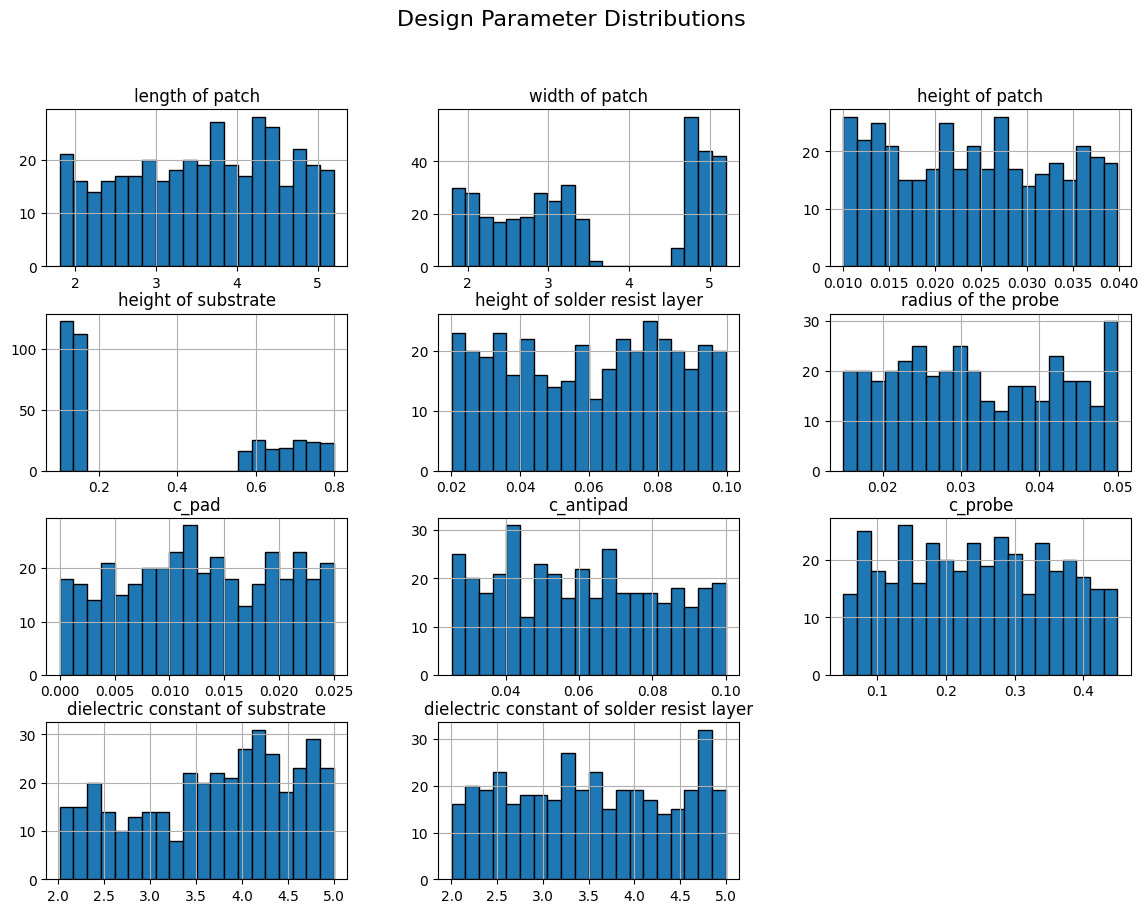

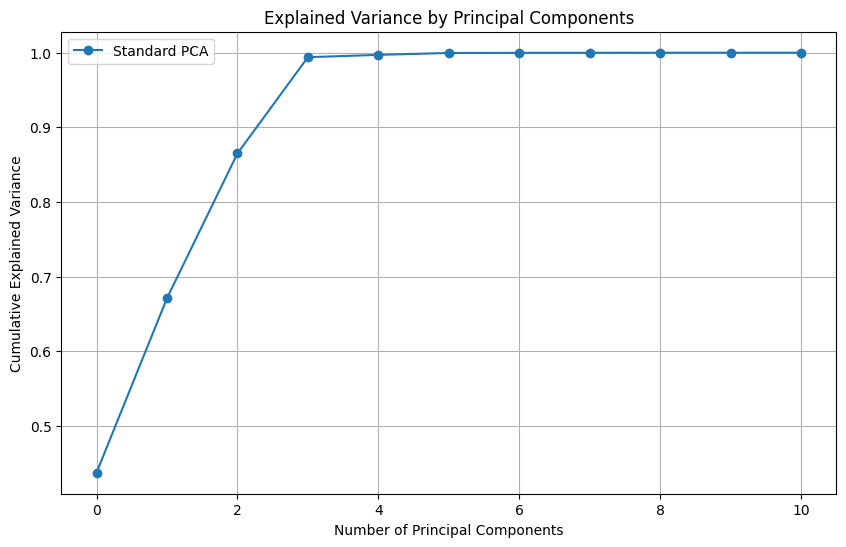

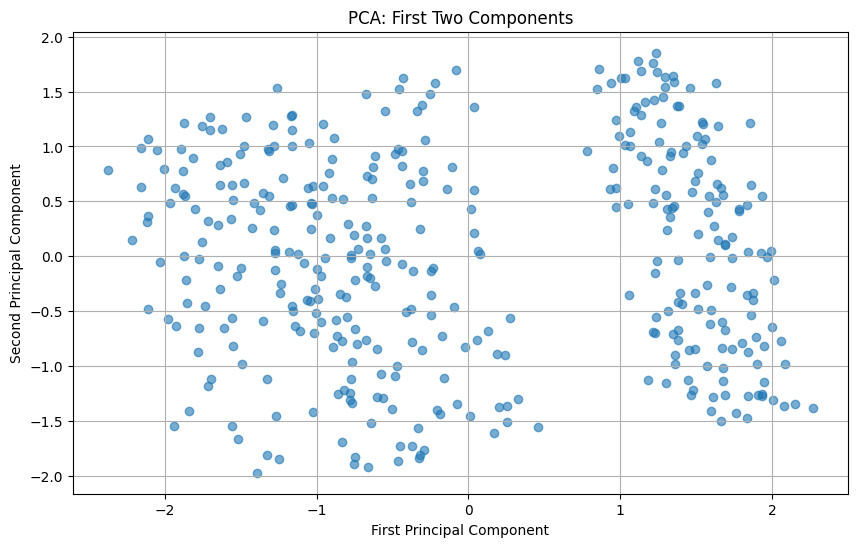

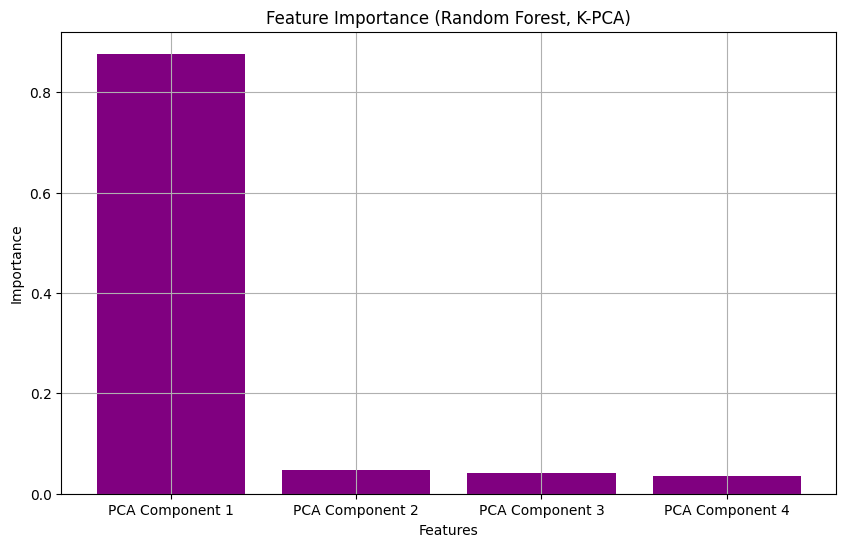

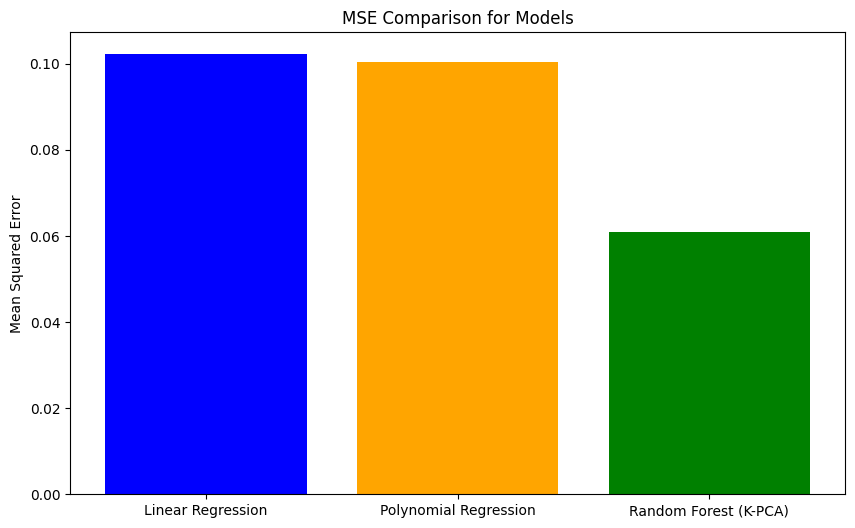

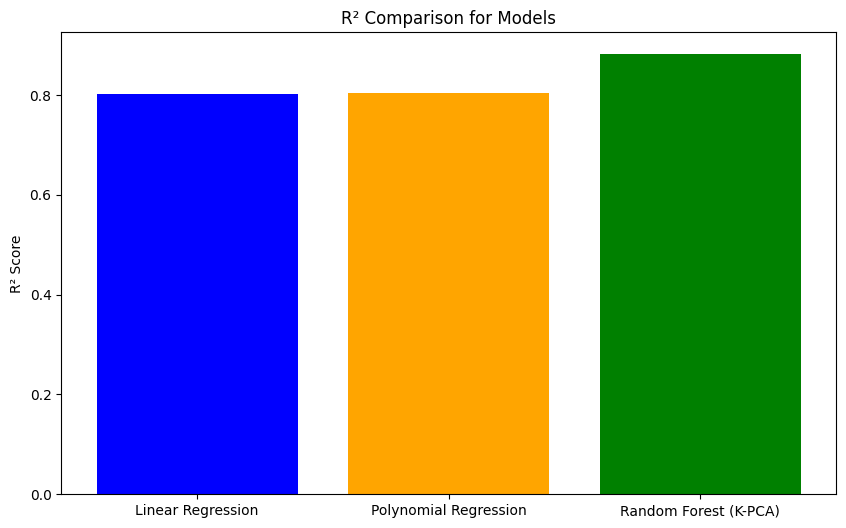

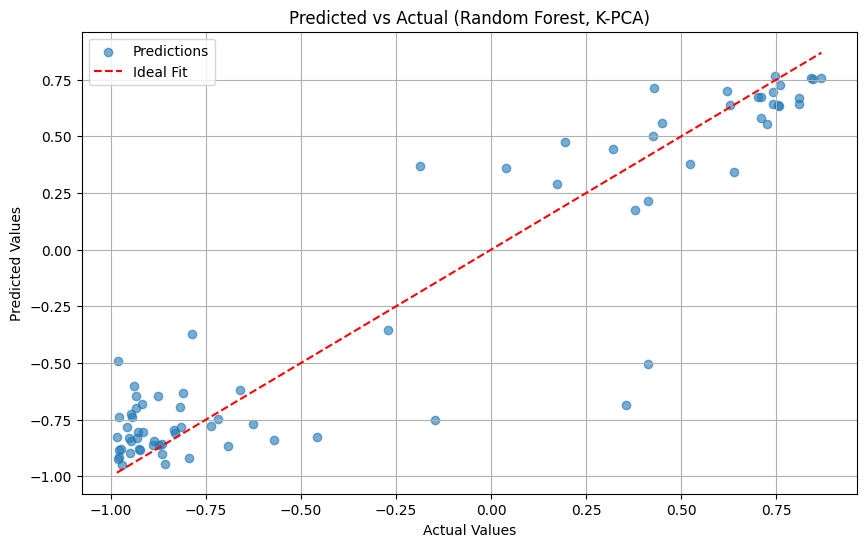

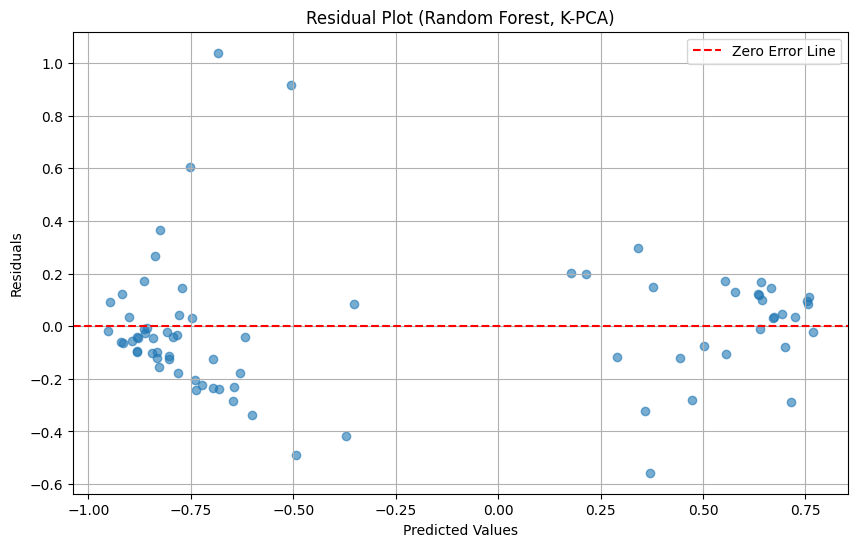

Cross-Validation R² Scores: [0.89078486 0.92918775 0.80502501 0.9144361  0.79597613]
Mean R² Score: 0.867081967992798
Model Performance Summary:
Linear Regression: MSE = 0.1022, R² = 0.8017
Polynomial Regression: MSE = 0.1005, R² = 0.8050
Random Forest (K-PCA): MSE = 0.0609, R² = 0.8817

Cross-Validation Results for Random Forest:
R² Scores: [0.89078486 0.92918775 0.80502501 0.9144361  0.79597613]
Mean R² Score: 0.8671

The best model is 'Random Forest (K-PCA)' with R² = 0.8817 and MSE = 0.0609.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
input_data_path = r'C:\Users\engin\OneDrive\Masaüstü\hw1_input.csv'
real_data_path = r'C:\Users\engin\OneDrive\Masaüstü\hw1_real.csv'
img_data_path = r'C:\Users\engin\OneDrive\Masaüstü\hw1_img.csv'

input_df = pd.read_csv(input_data_path)
real_df = pd.read_csv(real_data_path)
img_df = pd.read_csv(img_data_path)

# Exploratory data analysis: Feature distributions
input_df.hist(figsize=(14, 10), bins=20, edgecolor='black')
plt.suptitle('Design Parameter Distributions', fontsize=16)
plt.show()

# Standard PCA
pca = PCA()
input_df_pca = pca.fit_transform(input_df)

# Kernel PCA (RBF kernel)
kernel_pca = KernelPCA(kernel='rbf', gamma=0.1, n_components=4)
input_df_kpca = kernel_pca.fit_transform(input_df)

# Plot cumulative explained variance for standard PCA
explained_variance_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio), label='Standard PCA', marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.legend()
plt.show()

# Scatter plot for first two PCA components
plt.figure(figsize=(10, 6))
plt.scatter(input_df_pca[:, 0], input_df_pca[:, 1], alpha=0.6)
plt.title('PCA: First Two Components')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)
plt.show()

# Select principal components from both PCA and Kernel PCA
X_pca = input_df_pca[:, :4]
X_kpca = input_df_kpca
selected_frequencies = [str(freq) for freq in [50, 100, 150]]
y_real = real_df[selected_frequencies]
y_img = img_df[selected_frequencies]

# Split data into training and test sets
X_train_pca, X_test_pca, y_real_train, y_real_test = train_test_split(X_pca, y_real, test_size=0.2, random_state=42)
X_train_kpca, X_test_kpca, _, _ = train_test_split(X_kpca, y_real, test_size=0.2, random_state=42)

# 1. Linear Regression
model_real = LinearRegression()
model_real.fit(X_train_pca, y_real_train)
y_real_pred = model_real.predict(X_test_pca)

# 2. Polynomial Regression
poly_model_real = make_pipeline(PolynomialFeatures(2), LinearRegression())
poly_model_real.fit(X_train_pca, y_real_train)
y_real_poly_pred = poly_model_real.predict(X_test_pca)

# 3. Kernel PCA with Random Forest Regressor
rf_model_real = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_real.fit(X_train_kpca, y_real_train[selected_frequencies[0]])
y_real_rf_pred = rf_model_real.predict(X_test_kpca)

# Feature Importance for Random Forest
feature_importances = rf_model_real.feature_importances_
feature_names = [f'PCA Component {i+1}' for i in range(X_kpca.shape[1])]
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances, color='purple')
plt.title('Feature Importance (Random Forest, K-PCA)')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.grid(True)
plt.show()

# Model Performance Comparison
models = ['Linear Regression', 'Polynomial Regression', 'Random Forest (K-PCA)']
mse_values = [
    mean_squared_error(y_real_test[selected_frequencies[0]], y_real_pred[:, 0]),
    mean_squared_error(y_real_test[selected_frequencies[0]], y_real_poly_pred[:, 0]),
    mean_squared_error(y_real_test[selected_frequencies[0]], y_real_rf_pred)
]
r2_values = [
    r2_score(y_real_test[selected_frequencies[0]], y_real_pred[:, 0]),
    r2_score(y_real_test[selected_frequencies[0]], y_real_poly_pred[:, 0]),
    r2_score(y_real_test[selected_frequencies[0]], y_real_rf_pred)
]

plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color=['blue', 'orange', 'green'])
plt.title('MSE Comparison for Models')
plt.ylabel('Mean Squared Error')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, color=['blue', 'orange', 'green'])
plt.title('R² Comparison for Models')
plt.ylabel('R² Score')
plt.show()

# Visualize Predicted vs Actual for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_real_test[selected_frequencies[0]], y_real_rf_pred, alpha=0.6, label='Predictions')
plt.plot([min(y_real_test[selected_frequencies[0]]), max(y_real_test[selected_frequencies[0]])],
         [min(y_real_test[selected_frequencies[0]]), max(y_real_test[selected_frequencies[0]])], color='red', linestyle='--', label='Ideal Fit')
plt.title('Predicted vs Actual (Random Forest, K-PCA)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Residual Analysis
residuals = y_real_test[selected_frequencies[0]] - y_real_rf_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_real_rf_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.title('Residual Plot (Random Forest, K-PCA)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

# Cross-validation for Random Forest
scores = cross_val_score(rf_model_real, X_kpca, y_real[selected_frequencies[0]], cv=5, scoring='r2')
print(f"Cross-Validation R² Scores: {scores}")
print(f"Mean R² Score: {np.mean(scores)}")
print("Model Performance Summary:")
print(f"Linear Regression: MSE = {mse_values[0]:.4f}, R² = {r2_values[0]:.4f}")
print(f"Polynomial Regression: MSE = {mse_values[1]:.4f}, R² = {r2_values[1]:.4f}")
print(f"Random Forest (K-PCA): MSE = {mse_values[2]:.4f}, R² = {r2_values[2]:.4f}")
print("\nCross-Validation Results for Random Forest:")
print(f"R² Scores: {scores}")
print(f"Mean R² Score: {np.mean(scores):.4f}")
best_model = models[np.argmax(r2_values)]
print(f"\nThe best model is '{best_model}' with R² = {max(r2_values):.4f} and MSE = {min(mse_values):.4f}.")
